# Binary classification

Objective: 
For $d$ and $N$ given, find the complexity (number of discontinuities $L$) required by the control functions $(w,a,b)$ of a neural ODE 
\begin{equation}
\dot x = w(t)\sigma(a(t)\cdot x+b(t)),\qquad t\in(0,T)
\end{equation}
to classify a dataset $\{(x_i,y_i)\}_{i=1}^N$, where $x_i\sim U([0,1]^d)$ and $y_i\in\{0,1\}$ are randomly chosen for all $i$. 

Classification is understood as finding some controls $(w,a,b)$ such that the flow map $\Phi_T$ of the neural ODE satisfies 
\begin{equation*}
\Phi_T(x_i;w,a,b)^{(d)}>1\quad\text{for all }x_i\text{ such that }y_i=1,
\end{equation*} 
and 
\begin{equation*}
\Phi_T(x_i;w,a,b)^{(d)}<1\quad\text{for all }x_i\text{ such that }y_i=0.
\end{equation*}
Also, study the dependence of $L$ with $d$ and $N$.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from math import ceil
import random
from IPython.display import Image, display, clear_output

from Functions.training import doublebackTrainer
from Functions.neural_odes import NeuralODE
from Functions.plots import plot_data, plot_loss
from Functions.create import create_dataloader, create_paths, create_projector

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Matplotlib inline for IPython
%matplotlib inline

# Define constants for the dataset
distribution = 'uniformbalanced'  # Options: circles, blobs, moons, xor, uniform, uniformbalanced
N = 60  # Number of data points
d = 4  # Data dimensionality
rescale = True  # Rescale data to mean 0 and variance 1

# Define dynamics parameters
L = 12  # Number of discontinuities
hidden_dim = 1
T, num_vals = 60, L+1  # num_vals corresponds to the number of control values in [0, T]
learning_rate = 1e-3
non_linearity = 'trunrelu'  # Options: relu, tanh, sigmoid, leakyrelu, trunrelu, 2relu
architecture = 'bottleneck'  # Options: inside, outside, bottleneck
final_layer = True  # Add a final linear layer if output_dim = 1

# Define ODE solver parameters
method = 'euler'  # Options: euler, midpoint, dopri5, rk4
step_size = 0.25 * T / num_vals  # Step size for the ODE solver

# Display setup information
print(f'Data: {N} points {distribution} in $\mathbb{{R}}^{{{d}}}$ - Dynamics: {non_linearity} - Architecture: {architecture}')
print(f'Complexity: {num_vals-1} discontinuities')
print(f'Upper bound on complexity predicted by our algorithm: {2 * ceil(N / (2 * d)) - 1} discontinuities')

# Define training parameters
max_epochs = 70000  # Maximum number of epochs per training session
max_count = 20  # Maximum number of trials per dataset seed
verbose, adjoint = True, False  # Print loss at each epoch, use odeint_adjoint if True
loss_func = 'mse'  # Loss function: cross_entropy, mse, bce, linear_sep

output_dim = 2 if loss_func == 'cross_entropy' else 1
final_layer = True if output_dim == 1 else final_layer

print(f'Loss: {loss_func} - Max epochs: {max_epochs} - Learning rate: {learning_rate} - Step size: {step_size}')

# Additional options
noise = 0
fixed_projector = True  # Fix the linear layer if True
random_projector = False  # Use random weights for the fixed projector if True

if final_layer and fixed_projector:
    fixed_projector = create_projector(device, d, output_dim, random_projector)
    print(f'Fixed projector weights: \n{fixed_projector.weight} \n{fixed_projector.bias}')

# Ensure reproducibility
torch.backends.cudnn.deterministic = True

# Run the training loop
for k in range(10):
    seed_data, seed_train = k, 0
    classif = False
    count = 0

    # Create dataset
    datatrain, y, X0, X1 = create_dataloader(distribution, N=N, d=d, noise=noise, seed=seed_data, rescale=rescale)
    print(f'blue: {X0.shape}, red: {X1.shape}')

    while not classif and count < max_count:
        seed_params = random.randint(1, 1000)
        
        # Setup paths and plotting options
        export_fig, record_freq = True, 20
        if export_fig:
            full_path = create_paths(non_linearity, architecture, d, hidden_dim, num_vals, distribution, N, seed_data, seed_params, rescale)
        
        # Initialize and train the Neural ODE
        print("Training Neural ODE")
        node = NeuralODE(device, fixed_projector, d, hidden_dim, output_dim, non_linearity, adjoint, 
                         architecture, T, num_vals, step_size, method, final_layer, seed_params)
        optimizer = torch.optim.Adam(node.parameters(), lr=learning_rate)
        trainer = doublebackTrainer(node, optimizer, device, fixed_projector, loss_func, AdjTrainer=False,
                                    record_freq=record_freq, pathgifs=full_path, verbose=verbose)
        trainer.train(datatrain, max_epochs, full_path)
        
        # Save initial parameters
        variables = [seed_data, N, hidden_dim, d, T, num_vals, step_size, learning_rate, non_linearity, loss_func, architecture, max_epochs, random_projector]
        variable_names = ['seed_data', 'N', 'hidden_dim', 'd', 'T', 'num_vals', 'step_size', 'learning_rate', 'non_linearity', 'loss_func', 'architecture', 'max_epochs', 'Random projector']
        with open(os.path.join(full_path, "InitialValues.json"), "w") as f:
            json.dump(dict(zip(variable_names, variables)), f)
        
        clear_output(wait=True)
        
        # Plot loss and data
        plot_loss(trainer, full_path, export_fig=True)
        inputs, targets = [], []
        for batch_points, batch_labels in datatrain:
            inputs.append(batch_points)
            targets.append(batch_labels)
        inputs, targets = torch.cat(inputs), torch.cat(targets)
        
        initpts_path = plot_data(node, inputs, targets, N, dpi=400, alpha=0.9, path=full_path, init=True)
        finalpts_path = plot_data(node, inputs, targets, N, dpi=400, alpha=0.9, path=full_path, final=True)
        display(Image(filename=initpts_path, width=1000))
        display(Image(filename=finalpts_path, width=1000))
        
        if trainer.classif:
            classif = True
            dir_name, file_name = os.path.split(full_path)
            base, ext = os.path.splitext(file_name)
            new_file_name = f"{base} - Achieved{ext}"
            new_path = os.path.join(dir_name, new_file_name)
            os.rename(full_path, new_path)
        else:
            count += 1

    if count == max_count:
        dir_name, file_name = os.path.split(full_path)
        base, ext = os.path.splitext(file_name)
        new_file_name = f"{base} - Failed in {max_count} tests{ext}"
        new_path = os.path.join(dir_name, new_file_name)
        os.rename(full_path, new_path)
        break
def reset_seed(seed):
    torch.manual_seed(seed) # Set the seed for the random number generator
    torch.cuda.manual_seed(seed) # Set the seed for the operations in the GPU
    g = torch.Generator()
    g.manual_seed(seed)


<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_n/fn3gl4tx78v8ym53fcgcrmy80000gn/T/ipykernel_8609/3957404619.py:41: SyntaxWarning: invalid escape sequence '\m'
  print(f'Data: {N} points {distribution} in $\mathbb{{R}}^{{{d}}}$ - Dynamics: {non_linearity} - Architecture: {architecture}')


Data: 60 points uniformbalanced in $\mathbb{R}^{4}$ - Dynamics: trunrelu - Architecture: bottleneck
Complexity: 12 discontinuities
Upper bound on complexity predicted by our algorithm: 15 discontinuities
Loss: mse - Max epochs: 70000 - Learning rate: 0.001 - Step size: 1.1538461538461537
Fixed projector weights: 
Parameter containing:
tensor([[0., 0., 0., 1.]]) 
Parameter containing:
tensor([-0.5000])
blue: (30, 4), red: (30, 4)
Training Neural ODE


/Users/antonioalvarezlopez/Desktop/Coding/Neural ODEs/ClassificationWCS/Functions/create.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = y.clone().detach() if data_type == 'uniform' else torch.tensor(y, dtype=torch.long)


Running until epoch=70000
Epoch 1. Avg loss: 16.1980381012.
Saving model
Epoch 2. Avg loss: 15.4849529266.
Saving model
Epoch 3. Avg loss: 14.6538696289.
Saving model
Epoch 4. Avg loss: 13.6964864731.
Saving model
Epoch 5. Avg loss: 13.0678281784.
Saving model
Epoch 6. Avg loss: 12.4805212021.
Saving model
Epoch 7. Avg loss: 11.9819240570.
Saving model
Epoch 8. Avg loss: 11.5485038757.
Saving model
Epoch 9. Avg loss: 11.1471204758.
Saving model
Epoch 10. Avg loss: 10.7563171387.
Saving model
Epoch 11. Avg loss: 10.3805837631.
Saving model
Epoch 12. Avg loss: 10.0121126175.
Saving model
Epoch 13. Avg loss: 9.7003698349.
Saving model
Epoch 14. Avg loss: 9.4225053787.
Saving model
Epoch 15. Avg loss: 9.1331729889.
Saving model
Epoch 16. Avg loss: 8.8552904129.
Saving model
Epoch 17. Avg loss: 8.6309223175.
Saving model
Epoch 18. Avg loss: 8.4154233932.
Saving model
Epoch 19. Avg loss: 8.2152042389.
Saving model
Epoch 20. Avg loss: 8.0253562927.
Saving model
Epoch 21. Avg loss: 7.839580059

/var/folders/_n/fn3gl4tx78v8ym53fcgcrmy80000gn/T/ipykernel_8609/3957404619.py:41: SyntaxWarning: invalid escape sequence '\m'
  print(f'Data: {N} points {distribution} in $\mathbb{{R}}^{{{d}}}$ - Dynamics: {non_linearity} - Architecture: {architecture}')


KeyboardInterrupt: 

# Initialization of variables (data, dynamics, training)
The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting

In [1]:
# DATA:
distribution= 'uniform' # circles, blobs, moons, xor, uniform, uniformbalanced
N = 40 
noise = 0.0

# DYNAMICS:
d = 2
L = 10 #number of discontinuities
hidden_dim, augment_dim = 1, 0 
T, num_vals  = 40, L+1  # num_vals is the number of values taken by the PC controls in [0, T]
learning_rate = 1e-3
non_linearity = 'trunrelu' #relu, tanh, sigmoid, leakyrelu, trunrelu, krelu (k=2,3,4)
architecture = 'bottleneck' # inside, outside, bottleneck
method = 'euler' # euler, midpoint, dopri5, rk4
step_size = 0.25*T/num_vals # Step size for the ODE solver
final_layer = True # If True, the final layer is a linear layer (if output_dim = 1, it will automatically be True)
print(rf'Data: {N} points {distribution} in $\\mathbb{{R}}^{{{d}}}$ - Dynamics: {non_linearity} - Architecture: {architecture}')
print(f'Complexity: {num_vals-1} discontinuities')
print(f'Upper bound on complexity predicted by our algorithm: {2*ceil(N/d)-1} discontinuities')

# TRAINING:
max_epochs = 50000 # Number of epochs
verbose, adjoint = True, False # To print in the screen the loss at each epoch. To use the odeint_adjoint
loss_func = 'cross_entropy' # 'cross_entropy', 'mse', 'bce' (binary cross entropy)
if loss_func == 'cross_entropy':    
    output_dim = 2
else:
    output_dim = 1
    final_layer = True
print(f'Loss: {loss_func} - Maximum number of epochs: {max_epochs} - Learning rate: {learning_rate} - Step size: {step_size}')
          
# Additional options:
fixed_projector = True # If False, the linear layer is trained. If True, the linear layer is fixed
random_projector = False # If True, the fixed projector has random weights. If False, the fixed projector is a=(0,0,...,1), b=-1
if final_layer:
    if fixed_projector:
        fixed_projector = create_projector(device, d, output_dim, random_projector)
        print(f' - Fixed projector: \n{fixed_projector.weight} \n{fixed_projector.bias}')
turnpike, early_stopping, autostop= False, False, False

# SEEDS
torch.backends.cudnn.deterministic = True # To obtain reproducible results
seed_data, seed_params, seed_train = 0, 1, 1
reset_seed(seed_data)
    
    
# PLOTTING AND PATHS
plotlim, export_fig, record_freq = [-0.5, 1.5], True, 20 # Save the loss every record_freq epochs, Save an image every gif_freq epochs to create the gif. Put = 0 for no gif
if export_fig:
    full_path= create_paths(non_linearity, architecture, d, hidden_dim, num_vals, max_epochs, distribution, N, seed_data) 

# CREATION OF DATASETS
datatrain, X0, X1 = create_dataloader(distribution, N=N, d=d, noise=noise, plotlim=plotlim, path=full_path, seed=seed_data)
print('blue: ',X0.shape, 'red: ', X1.shape)

Data: 40 points uniform in $\\mathbb{R}^{2}$ - Dynamics: trunrelu - Architecture: bottleneck
Complexity: 10 discontinuities


NameError: name 'ceil' is not defined

# Dynamics and Training

In [ ]:
from Functions.neural_odes import NeuralODE
from Functions.training import doublebackTrainer
import time

start_time = time.time()
print(f"Training Neural ODE")

# Define the Neural ODE
node = NeuralODE(device, fixed_projector, d, hidden_dim, augment_dim=augment_dim, output_dim = output_dim, non_linearity=non_linearity, adjoint=adjoint, 
            architecture=architecture, T=T, num_vals=num_vals, step_size=step_size, method=method, final_layer=final_layer, seed_params=seed_params)

# Train the Neural ODE #choose doublebackTrainer for the double-backpropagation method or AdjTrainer for the adjoint method
optimizer = torch.optim.Adam(node.parameters(), lr=learning_rate)
trainer = doublebackTrainer(node, optimizer, device, fixed_projector, loss_func, AdjTrainer = False,
                            record_freq=record_freq, pathgifs=full_path, plotlim=plotlim, verbose=verbose)
trainer.train(datatrain, max_epochs, full_path)
    
end_time = time.time()
trainingtime = end_time - start_time
print('Training time:  ',trainingtime)

variables = [seed_data, N, hidden_dim, d, augment_dim, T, num_vals, step_size, learning_rate, non_linearity, loss_func, architecture, max_epochs, random_projector, trainingtime]
variable_names = ['seed_data', 'N', 'hidden_dim', 'd', 'augment_dim', 'T', 'num_vals', 'step_size', 'learning_rate', 'non_linearity', 'loss_func', 'architecture', 'max_epochs', 'Random projector', 'Training time']

# SAVING INITIAL VALUES IN TXT AND JSON
with open(os.path.join(full_path, "InitialValues.txt"), "w") as f:
    for name, value in zip(variable_names, variables):
        f.write(f"{name}={value}\n")
with open(os.path.join(full_path, "InitialValues.json"), "w") as f:
   json.dump(dict(zip(variable_names, variables)), f)

Training Neural ODE
Running until epoch=50000
Epoch 1. Avg loss: 49.9057502747.
Saving model
Epoch 2. Avg loss: 40.4795417786.
Saving model
Epoch 3. Avg loss: 32.8598899841.
Saving model
Epoch 4. Avg loss: 26.3795909882.
Saving model
Epoch 5. Avg loss: 20.7443904877.
Saving model
Epoch 6. Avg loss: 16.0948429108.
Saving model
Epoch 7. Avg loss: 12.3744564056.
Saving model
Epoch 8. Avg loss: 9.8027210236.
Saving model
Epoch 9. Avg loss: 7.9787282944.
Saving model
Epoch 10. Avg loss: 6.7528738976.
Saving model
Epoch 11. Avg loss: 5.8674497604.
Saving model
Epoch 12. Avg loss: 5.1983933449.
Saving model
Epoch 13. Avg loss: 4.6352357864.
Saving model
Epoch 14. Avg loss: 4.2125358582.
Saving model
Epoch 15. Avg loss: 3.8758435249.
Saving model
Epoch 16. Avg loss: 3.6145865917.
Saving model
Epoch 17. Avg loss: 3.3641533852.
Saving model
Epoch 18. Avg loss: 3.1647226810.
Saving model
Epoch 19. Avg loss: 3.0469601154.
Saving model
Epoch 20. Avg loss: 3.0003707409.
Saving model
Epoch 21. Avg lo

# CONTINUE TRAINING OR LOAD PARAMETERS

In [ ]:

#trainer.keep_training(datatrain, max_epochs=50000, newtol_trainerror=0.001, pathparams=full_path)

load = False #change to True if you want to load the saved best parameters
if load:
    node=(NeuralODE(device, fixed_projector, d, hidden_dim, augment_dim=augment_dim, output_dim = output_dim, non_linearity=non_linearity, adjoint=adjoint, 
            architecture=architecture, T=T, num_vals=num_vals, step_size=step_size, method=method, final_layer=final_layer, seed_params=seed_params))
    file_path = os.path.join(full_path, f'best_param_NODE.pt')
    load_params = torch.load(file_path)
    node.load_state_dict(load_params)

# Comparative Table

In [ ]:
import pandas as pd

specific_epochs = [trainer.model.best_epoch // 4, trainer.model.best_epoch // 2, 3 * trainer.model.best_epoch // 4, trainer.model.best_epoch]
columns = [f"Epoch {epoch}" for epoch in specific_epochs] + ['Best Epoch']
full_path_excel = os.path.join(full_path, 'Losses.xlsx')

data = []
row = [trainer.histories['loss_history'][epoch - 1] for epoch in specific_epochs]
min_loss = min(trainer.histories['loss_history'])
min_epoch = trainer.histories['loss_history'].index(min_loss) + 1
row.append(f"{min_loss:.5f} (Ep {min_epoch})")
data.append(row)

# Create DataFrame
df = pd.DataFrame(data, columns=columns)
df.to_excel(full_path_excel, sheet_name='Loss History', index=False)
print(df)

   Epoch 11824  Epoch 23648  Epoch 35472  Epoch 47297          Best Epoch
0     0.074372     0.025382      0.01574     0.015664  0.01566 (Ep 47298)


# Visualization of the level sets

In [ ]:
#levelsets(node, path=full_path, fig_name=f'Level set', plotlim = plotlim, step = 0.01, dpi = 200, points = (X0,X1))

# Evolution of the loss term

In [ ]:

log_histories = np.log10(trainer.histories['loss_history'])
fig = plt.figure(figsize=(8, 24),dpi=500)

plt.figure()
title = 'Error vs Training epochs'
if log_scale:
    title = 'log ' + title
plt.title(title)
plt.plot(trainer.histories['loss_history'], color='b',linewidth=2)
plt.xlabel('epochs')
plt.xlim(0, len(trainer.histories['loss_history']) - 1)
plt.grid() 
plt.tight_layout()
if export_fig==True:
    pathfigslosses = os.path.join(full_path, 'LossVsEpochs.png')
    plt.savefig(pathfigslosses, bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()


NameError: name 'log_scale' is not defined

<Figure size 4000x12000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Visualization of trajectories

FileNotFoundError: [Errno 2] No such file or directory: 'Results/uniformbalanced/Sigma=trunrelu_Arch=bottleneck_Width=1/2N=10_Dim=2_L=8/DS0PS471Results1/trajectories_final.png'

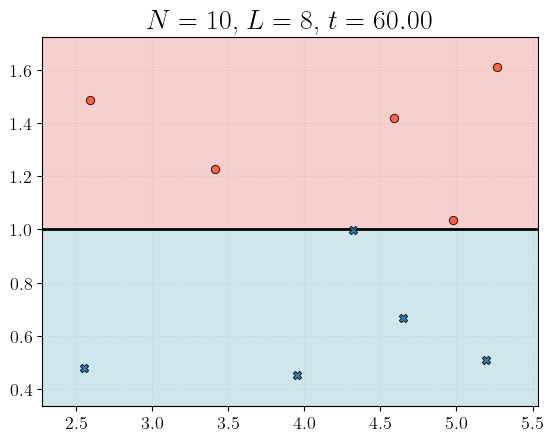

In [2]:
from Functions.gifs import traj_gif, traj_gif_3d
from Functions.plots import plot_data

num_samples = N  # Number of input points to plot the trajectories
inputs, targets = [], []
for batch_points, batch_labels in datatrain:
    inputs.append(batch_points)
    targets.append(batch_labels)
inputs = torch.cat(inputs)
targets = torch.cat(targets)

fps = 1  # Frames per second for the GIFs
#Options:
dyn_lims, normalize, hyperplane, trajs = True, False, True, True # If True, the limits of the plot are dynamic. If True, the plot is normalized. If True, the hyperplane is plotted. If True, paths are plotted

finalpts_path = plot_data(node, inputs, targets, dpi=400, alpha=0.9, path=full_path, final=True)

display(Image(filename=finalpts_path, width=1000))
    